In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data imports

In [ ]:
# read data for chicken farm
data_for_model = pd.read_csv(r'C:\Users\Shivm\Documents\Masters\Research Project\Eskom air quality data\Eskom Model\PM10 Models\Combined Station Data.csv')
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model = data_for_model[data_for_model['Location_Chicken Farm']==True]
data_for_model['NO1'] = data_for_model['NO1'].fillna(data_for_model['NOX'] - data_for_model['NO2'])

data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
170376,2016/01/01 00:00:00,2.329133,354.089400,3.705,1.414,15.72,NaN,-0.239846,2.316751,NaN,847.0,21.26,15.470,2016-01-01 00:00:00,0.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.329133,NaN,2.329133,NaN,2.329133,NaN,2.329133,NaN,354.089400,NaN,354.089400,NaN,354.089400,NaN,354.089400,NaN,3.705000,NaN,3.705000,NaN,3.705000,NaN,3.705000,NaN,1.414000,NaN,1.414000,NaN,1.414000,NaN,1.414000,NaN,15.720000,NaN,15.720000,NaN,15.720000,NaN,15.720000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.239846,NaN,-0.239846,NaN,-0.239846,NaN,-0.239846,NaN,2.316751,NaN,2.316751,NaN,2.316751,NaN,2.316751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,847.000000,NaN,847.000000,NaN,847.000000,NaN,847.000000,NaN,21.260000,NaN,21.260000,NaN,21.260000,NaN,21.260000,NaN,15.470000,NaN,15.470000,NaN,15.470000,NaN,15.470000,NaN,False,True,False,False,False,False,False,False,False,True,False,True,False
170377,2016/01/01 00:10:00,2.495695,347.291100,4.064,4.243,13.44,NaN,-0.549047,2.434551,NaN,847.0,20.61,9.950,2016-01-01 00:10:00,0.0,1.0,4.0,2.329133,354.089400,3.705,1.414,15.72,NaN,-0.239846,2.316751,NaN,847.0,21.26,15.470,2.412414,0.117777,2.412414,0.117777,2.412414,0.117777,2.412414,0.117777,350.690250,4.807124,350.690250,4.807124,350.690250,4.807124,350.690250,4.807124,3.884500,0.253851,3.884500,0.253851,3.884500,0.253851,3.884500,0.253851,2.828500,2.000405,2.828500,2.000405,2.828500,2.000405,2.828500,2.000405,14.580000,1.612203,14.580000,1.612203,14.580000,1.612203,14.580000,1.612203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.394447,0.218638,-0.394447,0.218638,-0.394447,0.218638,-0.394447,0.218638,2.375651,0.083298,2.375651,0.083298,2.375651,0.083298,2.375651,0.083298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,847.000000,0.00000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,20.935000,0.459619,20.935000,0.459619,20.935000,0.459619,20.935000,0.459619,12.710000,3.903229,12.710000,3.903229,12.710000,3.903229,12.710000,3.903229,False,True,False,False,F

In [10]:
#null checks
data_for_model.isna().sum()

Date                  0
Wind                  0
Wind Dir              6
SO2                2971
NO2                8906
                   ... 
Season_Spring         0
Season_Summer         0
Season_Winter         0
DayType_Weekday       0
DayType_Weekend       0
Length: 138, dtype: int64

In [11]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year
data_for_model.drop(columns=['Date', 'Date Time'], inplace=True)


In [12]:
data_for_model.columns

Index(['Wind', 'Wind Dir', 'SO2', 'NO2', 'NOX', 'PM10', 'wind_x', 'wind_y',
       'PM2.5', 'Pressure',
       ...
       'Location_Marapong', 'Location_Medupi', 'Location_Phola',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'DayType_Weekday', 'DayType_Weekend', 'Year'],
      dtype='object', length=137)

## Create Target variable and rolling features

In [ ]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
data_for_model['PM2.5_lag2'] = data_for_model['PM2.5'].shift(2)
data_for_model['PM2.5_lag3'] = data_for_model['PM2.5'].shift(3)
#data_for_model['PM2.5_t+1'] = data_for_model['PM2.5'].shift(-1)
data_for_model['PM2.5_t+24'] = data_for_model['PM2.5'].shift(-24)
#data_for_model['PM2.5_t+6'] = data_for_model['PM2.5'].shift(-6)
#data_for_model['PM2.5_t+12'] = data_for_model['PM2.5'].shift(-12)


# Rolling means with different windows, shifted by 1 to prevent leakage
# data_for_model['PM2.5_roll3_mean'] = data_for_model['PM2.5'].rolling(window=3).mean().shift(1)
# data_for_model['PM2.5_roll6_mean'] = data_for_model['PM2.5'].rolling(window=6).mean().shift(1)
# data_for_model['PM2.5_roll12_mean'] = data_for_model['PM2.5'].rolling(window=12).mean().shift(1)
# data_for_model['PM2.5_roll24_mean'] = data_for_model['PM2.5'].rolling(window=24).mean().shift(1)
# data_for_model['PM2.5_roll3_std'] = data_for_model['PM2.5'].rolling(3).std().shift(1)
# data_for_model['PM2.5_roll6_std'] = data_for_model['PM2.5'].rolling(6).std().shift(1)
# data_for_model['PM2.5_roll12_std'] = data_for_model['PM2.5'].rolling(12).std().shift(1)
# data_for_model['PM2.5_roll24_std'] = data_for_model['PM2.5'].rolling(24).std().shift(1)
data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)


data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
df_train = data_for_model[(data_for_model['Year'] >= 2005) & (data_for_model['Year'] <= 2016)]
df_test = data_for_model[data_for_model['Year'] == 2017]
df_val = data_for_model[data_for_model['Year'] == 2018]


In [14]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,5.942719,101.66950,20.56,1.167,17.69,130.70,5.819887,-1.202010,46.89,844.0,22.58,18.970,16.0,1.0,4.0,5.726794,101.24370,25.670,0.808,18.100,131.10,5.616878,-1.116624,56.57,843.0,22.97,22.440,5.877713,0.131117,5.957474,0.192170,4.568106,1.739243,3.174689,1.899496,102.675667,2.122192,104.760750,2.882830,102.676012,80.582076,166.658048,140.759969,23.706667,2.752859,27.833333,6.922389,19.489750,12.380677,12.195458,11.351120,1.024667,0.190694,1.417333,0.447251,1.436000,0.758046,1.508083,0.891103,18.256667,0.659116,23.015000,6.195397,18.565833,6.801520,15.794583,5.688862,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,5.731369,0.103967,5.754497,0.189338,3.900370,2.483718,1.782339,2.794949,-1.291191,0.232367,-1.517910,0.298229,-0.106929,1.735630,0.769772,1.542737,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,843.333333,0.57735,843.500000,0.547723,843.750000,0.452267,844.041667,0.550033,23.103333,0.601193,24.061667,1.147091,26.131667,2.488763,27.155417,2.069247,22.023333,2.867792,27.085000,6.280830,21.193333,8.045835,17.061667,7.036463,False,True,False,False,False,False,False,False,False,True,False,True,False,2016,51.61,-9.68,-0.39
1,6.538234,94.81412,17.24,1.212,12.66,141.30,6.515168,-0.548711,51.60,843.0,22.84,15.760,16.0,1.0,4.0,5.942719,101.66950,20.560,1.167,17.690,130.70,5.819887,-1.202010,46.89,844.0,22.58,18.970,6.069249,0.420257,6.086508,0.277349,4.946141,1.619630,3.344257,2.012038,99.242440,3.840943,102.440637,4.298799,82.610930,33.584896,156.680045,136.792509,21.156667,4.246555,23.923333,4.348249,20.543083,11.505474,12.692167,11.297831,1.062333,0.221405,1.316500,0.405362,1.290167,0.586768,1.459458,0.873173,16.150000,3.029373,19.535000,4.810463,18.365833,6.947697,15.753333,5.708644,134.366667,6.007773,134.366667,6.007773,134.366667,6.007773,134.366667,6.007773,5.983978,0.471090,5.930587,0.311218,4.512227,2.085731,2.098432,2.88

## Correlation Matrix to identify best features

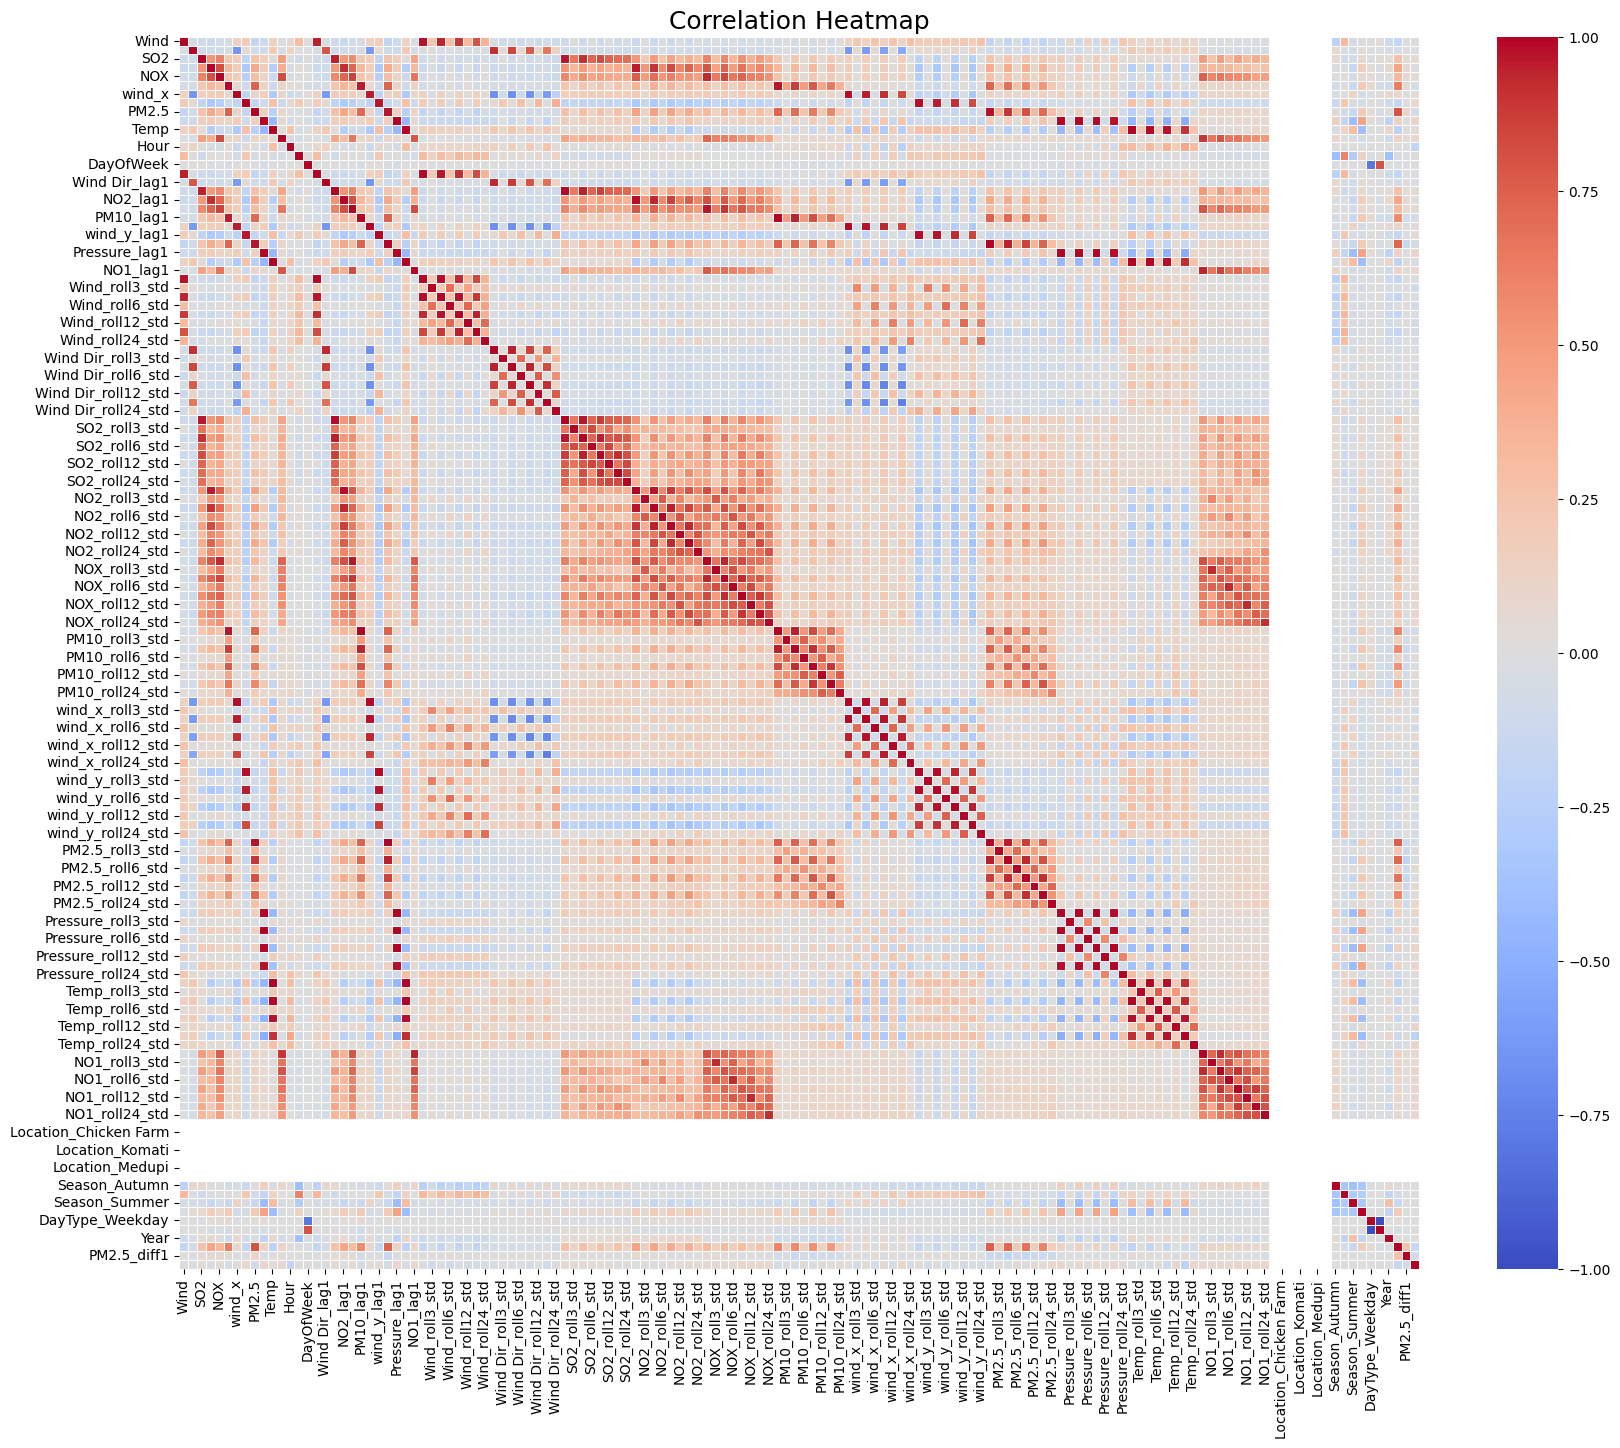

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [ ]:
# Compute correlations with the target
target = 'PM2.5_t+24'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+24:\n")
print(feature_ranking.head(20))

Top correlated features with PM2.5_t+3:

PM2.5                0.801467
PM2.5_roll3_mean     0.751820
PM2.5_lag1           0.728598
PM2.5_roll6_mean     0.719066
PM2.5_roll12_mean    0.676141
PM10                 0.626818
PM2.5_roll24_mean    0.607607
PM10_roll3_mean      0.594337
PM10_lag1            0.575835
PM10_roll6_mean      0.572280
PM10_roll12_mean     0.545944
PM10_roll24_mean     0.505552
NO2_roll3_mean       0.447755
NO2                  0.440607
NO2_roll6_mean       0.437539
NO2_lag1             0.433151
NO2_roll12_mean      0.413352
NO2_roll24_mean      0.375868
NOX_roll3_mean       0.330307
NOX_roll6_mean       0.320985
Name: PM2.5_t+3, dtype: float64


In [17]:
feature_ranking

PM2.5                 0.801467
PM2.5_roll3_mean      0.751820
PM2.5_lag1            0.728598
PM2.5_roll6_mean      0.719066
PM2.5_roll12_mean     0.676141
                        ...   
Location_Grootvlei         NaN
Location_Komati            NaN
Location_Marapong          NaN
Location_Medupi            NaN
Location_Phola             NaN
Name: PM2.5_t+3, Length: 139, dtype: float64

In [18]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_t+3,PM2.5_diff1,Temp_diff1
0,5.942719,101.66950,20.56,1.167,17.69,130.70,5.819887,-1.202010,46.89,844.0,22.58,18.970,16.0,1.0,4.0,5.726794,101.24370,25.670,0.808,18.100,131.10,5.616878,-1.116624,56.57,843.0,22.97,22.440,5.877713,0.131117,5.957474,0.192170,4.568106,1.739243,3.174689,1.899496,102.675667,2.122192,104.760750,2.882830,102.676012,80.582076,166.658048,140.759969,23.706667,2.752859,27.833333,6.922389,19.489750,12.380677,12.195458,11.351120,1.024667,0.190694,1.417333,0.447251,1.436000,0.758046,1.508083,0.891103,18.256667,0.659116,23.015000,6.195397,18.565833,6.801520,15.794583,5.688862,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,5.731369,0.103967,5.754497,0.189338,3.900370,2.483718,1.782339,2.794949,-1.291191,0.232367,-1.517910,0.298229,-0.106929,1.735630,0.769772,1.542737,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,843.333333,0.57735,843.500000,0.547723,843.750000,0.452267,844.041667,0.550033,23.103333,0.601193,24.061667,1.147091,26.131667,2.488763,27.155417,2.069247,22.023333,2.867792,27.085000,6.280830,21.193333,8.045835,17.061667,7.036463,False,True,False,False,False,False,False,False,False,True,False,True,False,2016,51.61,-9.68,-0.39
1,6.538234,94.81412,17.24,1.212,12.66,141.30,6.515168,-0.548711,51.60,843.0,22.84,15.760,16.0,1.0,4.0,5.942719,101.66950,20.560,1.167,17.690,130.70,5.819887,-1.202010,46.89,844.0,22.58,18.970,6.069249,0.420257,6.086508,0.277349,4.946141,1.619630,3.344257,2.012038,99.242440,3.840943,102.440637,4.298799,82.610930,33.584896,156.680045,136.792509,21.156667,4.246555,23.923333,4.348249,20.543083,11.505474,12.692167,11.297831,1.062333,0.221405,1.316500,0.405362,1.290167,0.586768,1.459458,0.873173,16.150000,3.029373,19.535000,4.810463,18.365833,6.947697,15.753333,5.708644,134.366667,6.007773,134.366667,6.007773,134.366667,6.007773,134.366667,6.007773,5.983978,0.471090,5.930587,0.311218,4.512227,2.085731,2.098432,2.88

## Feature Selection

In [ ]:
features = feature_ranking.head(20).index.tolist()

In [20]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+3'], df_test['PM2.5_t+3']])#data_for_model['PM2.5_t+3']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [21]:
y

0        51.610
1        48.710
2        43.650
3        35.660
4        30.970
          ...  
89174     5.771
89175     8.420
89176    11.070
89177    11.190
89178     7.019
Name: PM2.5_t+3, Length: 89179, dtype: float64

## Data splitting for models

In [22]:
# Let's use 80% of the data for training, 20% for testing
split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## LSTM Model (Neural Network)

In [23]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 230.7286 - val_loss: 123.4832
Epoch 2/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 96.5767 - val_loss: 113.0702
Epoch 3/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 87.3391 - val_loss: 115.1718
Epoch 4/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 93.3507 - val_loss: 111.4021
Epoch 5/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 95.9581 - val_loss: 110.8514
Epoch 6/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 83.0249 - val_loss: 110.9946
Epoch 7/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 89.6236 - val_loss: 107.7145
Epoch 8/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 83.8124 - val_loss: 110.9832
Epoch 9/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 88.0658 - val_loss: 106.2927
Epoch 10/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 84.1829 - val_loss: 125.6734
Epoch 11/50
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 82.7089 - val_loss: 107.5

In [24]:
#Prediction accuracy
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R²: 0.7556695266249011
RMSE: 10.233349492921153


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [25]:
#Validation data prediction
X_val = df_val[features]
y_val = df_val['PM2.5_t+3']

X_val_scaled = scaler.fit_transform(X_val)


y_pred_val = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
R²: 0.6940251261955632
RMSE: 10.3259458280218


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_3hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (3 hrs ahead): {forecast_3hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Forecasted PM2.5 (3 hrs ahead): 33.5201301574707


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


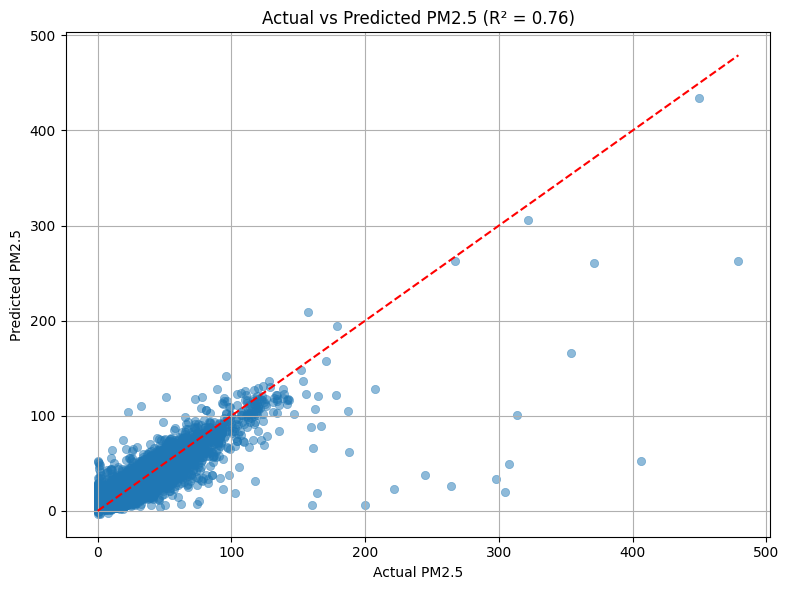

In [27]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
y_val

89179      6.033
89180      7.967
89181     12.030
89182     12.600
89183     13.200
           ...  
103487    23.430
103488    29.240
103489    31.590
103490    27.970
103491    24.740
Name: PM2.5_t+3, Length: 14313, dtype: float64

# Testing out XGBoost Regressor and Random Forrest Regressor

In [ ]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+3'], df_test['PM2.5_t+3']])#data_for_model['PM2.5_t+2444']

In [30]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
#Random Forrest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [32]:
#XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


## Model Evaluation

In [33]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 5.8184838769903555
RMSE: 9.737755664149738
R2 Score: 0.7356680390295767

XGBoost Performance:
MAE: 5.8360679017184065
RMSE: 9.453439501630793
R2 Score: 0.7508782592561221


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

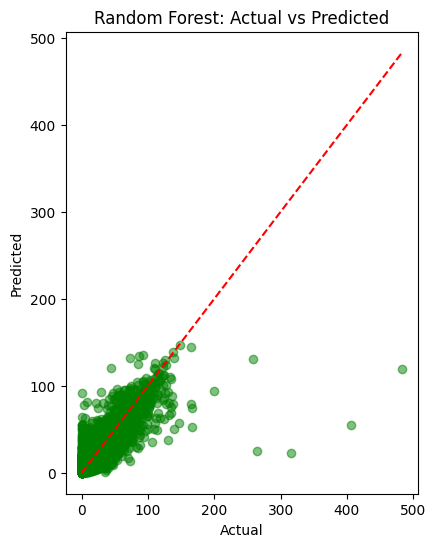

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

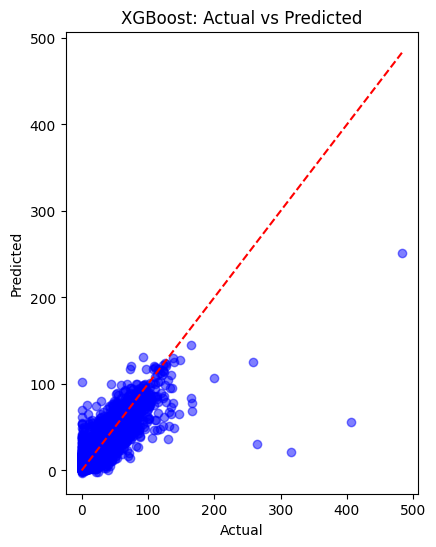

In [35]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

In [36]:
#Validation performance

rf_val = rf.predict(X_val)

xgb_val = xgb.predict(X_val)

evaluate_model("Random Forrest", y_val, rf_val)
evaluate_model("XGBoost", y_val, xgb_val )


Random Forrest Performance:
MAE: 6.5646913868511145
RMSE: 11.231703916188986
R2 Score: 0.6379926633228656

XGBoost Performance:
MAE: 6.386760958389484
RMSE: 11.197190220747501
R2 Score: 0.6402140563445714


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest Validation: Actual vs Predicted')

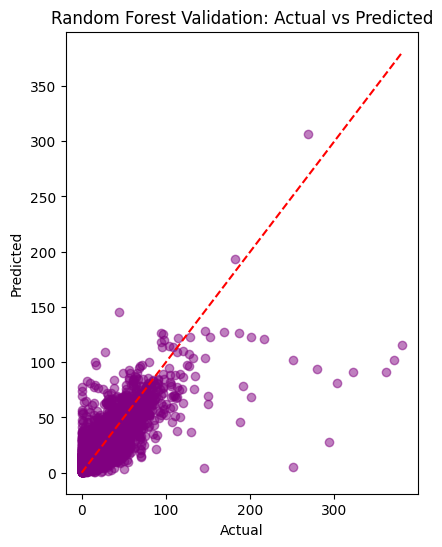

In [37]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, rf_val, alpha=0.5, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Validation: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost Validation: Actual vs Predicted')

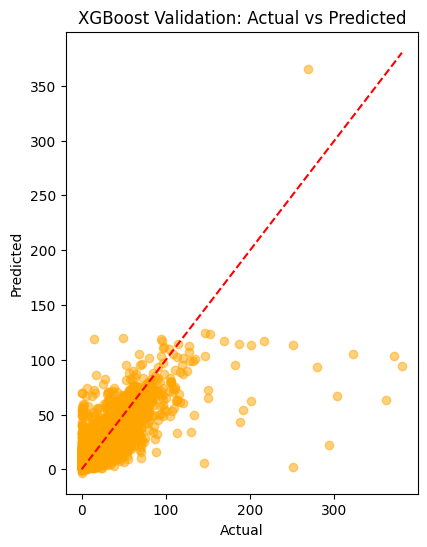

In [38]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, xgb_val, alpha=0.5, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Validation: Actual vs Predicted")

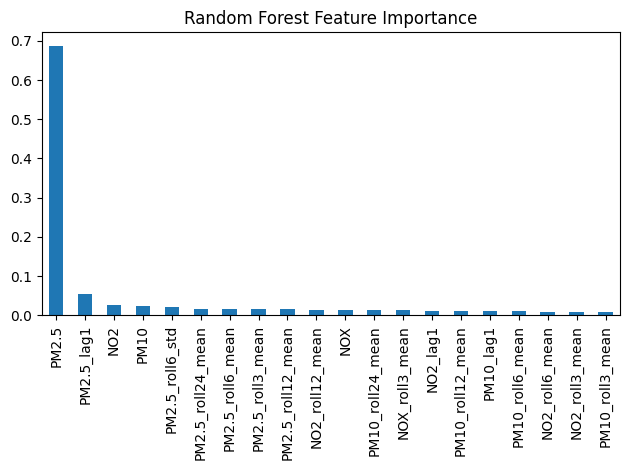

In [39]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()




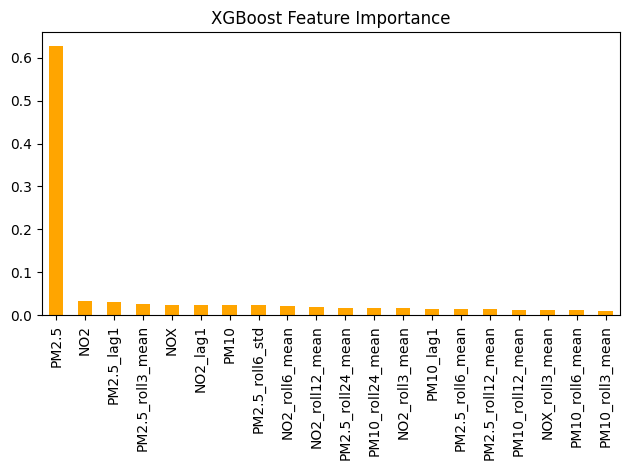

In [40]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()